In [1]:

!pip install nltk bert-score

In [2]:

import re
import string
import pickle
import pandas as pd
import numpy as np
import unicodedata
import random
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import matplotlib.pyplot as plt
import nltk
from unicodedata import normalize
from pickle import dump
from io import open
from collections import defaultdict
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler
from torch import optim
from torchtext.data import get_tokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from bert_score import score as bert_score_func
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score

c:\Users\rbalu\anaconda3\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
WEIGHTS_FOLDER = ""

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {device}')

Running on cpu


In [6]:
def read_file(file_name):
    with open(file_name, mode='rt', encoding='utf-8') as file:
        return file.read()

def process_sentences(text):
    sentences = text.strip().split('\n')
    regex_statement = re.compile('[^%s]' % re.escape(string.printable))
    translation_table = str.maketrans('', '', string.punctuation)

    filtered_sentences = []
    for line in sentences:
        line = normalize('NFD', line).encode('ascii', 'ignore').decode('UTF-8')
        words = [word.lower().translate(translation_table) for word in line.split()]
        words = [regex_statement.sub('', word) for word in words if word.isalpha()]
        filtered_sentences.append(' '.join(words))

    return filtered_sentences

def save_processed_sentences(filtered_sentences, output_filename):
    with open(output_filename, 'wb') as file:
        pickle.dump(filtered_sentences, file)

def process_input_text(file_name, output_filename):
    text = read_file(file_name)
    filtered_sentences = process_sentences(text)
    save_processed_sentences(filtered_sentences, output_filename)
    return filtered_sentences

filtered_sentences1 = process_input_text('europarl-v7.ro-en.en', 'english.pkl')
print("Saved English sentences to english.pkl file")

filtered_sentences2 = process_input_text('europarl-v7.ro-en.ro', 'romanian.pkl')
print("Saved Romanian sentences to romanian.pkl file")

Saved English sentences to english.pkl file
Saved Romanian sentences to romanian.pkl file


In [7]:
def load_vocabulary(english_filename, romanian_filename):
    with open(english_filename, 'rb') as f:
        english_vocabulary = pickle.load(f)
    with open(romanian_filename, 'rb') as f:
        romanian_vocabulary = pickle.load(f)

    data = pd.DataFrame({
        'English': english_vocabulary,
        'Romanian': romanian_vocabulary
    })

    return english_vocabulary, romanian_vocabulary, data

english_vocabulary, romanian_vocabulary, vocabulary_data = load_vocabulary('english.pkl', 'romanian.pkl')

In [8]:
def prepare_data_for_training_and_validation(english_vocabulary, romanian_vocabulary, combined_vocabulary):
    combined_vocabulary_list = list(zip(english_vocabulary, romanian_vocabulary))

    training_size = int(len(combined_vocabulary_list) * 0.70)
    validation_size = int(len(combined_vocabulary_list) * 0.30)

    combined_training_vocabulary = combined_vocabulary_list[:training_size]
    combined_validation_vocabulary = combined_vocabulary_list[training_size: training_size + validation_size]

    return combined_training_vocabulary, combined_validation_vocabulary

combined_training_vocabulary, combined_validation_vocabulary = prepare_data_for_training_and_validation(english_vocabulary, romanian_vocabulary, vocabulary_data)

In [9]:
def process_language(language_name, sentences):
    word_to_index = {"Start": 0, "End": 1}
    index_to_word = {0: "Start", 1: "End"}
    word_count_dictionary = defaultdict(int)
    total_number_of_words = 2

    for sentence in sentences:
        for word in sentence.split():
            if word not in word_to_index:
                word_to_index[word] = total_number_of_words
                index_to_word[total_number_of_words] = word
                total_number_of_words += 1
            word_count_dictionary[word] += 1

    return {
        "language_name": language_name,
        "word_to_index": word_to_index,
        "index_to_word": index_to_word,
        "word_count_dictionary": dict(word_count_dictionary),
        "total_number_of_words": total_number_of_words
    }

In [10]:
english_prefixes = tuple(map(lambda x: x.lower(), ["i am ", "i m ", "he is", "he s ", "she is", "she s ", "you are", "you re ", "we are", "we re ", "they are", "they re ", "I don t", "Do you", "I want", "Are you", "I have", "I think", "I can t", "I was", "He is", "I m not", "This is", "I just", "I didn t", "I am", "I thought", "I know", "Tom is", "I had", "Did you", "Have you", "Can you", "He was", "You don t", "I d like", "It was", "You should", "Would you", "I like", "It is", "She is", "You can t", "He has", "What do", "If you", "I need", "No one", "You are", "You have", "I feel", "I really", "Why don t", "I hope", "I will", "We have", "You re not", "You re very", "She was", "I love", "You must", "I can"]))
sentence_length = 17



In [11]:
def split_sentences(cv):
    return len(cv[0].split(' ')) < sentence_length and \
           len(cv[1].split(' ')) < sentence_length and \
           cv[1].lower().startswith(english_prefixes)

def split_english_and_romanian(combined_vocabularies):
    return [cv for cv in combined_vocabularies if split_sentences(cv)]

def prepare_data(english, romanian, combined_vocabularies_total, reverse=False):
    if reverse:
        combined_vocabularies_total = [list(reversed(cv)) for cv in combined_vocabularies_total]

    combined_vocabularies = split_english_and_romanian(combined_vocabularies_total)
    english_data = process_language(english, [cv[0] for cv in combined_vocabularies])
    romanian_data = process_language(romanian, [cv[1] for cv in combined_vocabularies])

    return english_data, romanian_data, combined_vocabularies

In [12]:
training_romanian_sentence, training_english_sentence, combined_vocabularies_for_training = prepare_data("English", "Romanian", combined_training_vocabulary, reverse=True)
validation_romanian_sentence, validation_english_sentence, combined_vocabularies_for_validation = prepare_data("English", "Romanian", combined_validation_vocabulary, reverse=True)

In [13]:
def tensor_from_sentences(language_data, sentence):
    word_index = [language_data['word_to_index'].get(word, 0) for word in sentence.split(' ')]
    word_index.append(1)

    while len(word_index) < sentence_length:
        word_index.append(2)

    return torch.LongTensor(word_index)

def get_tensor_vocabularies(combined_vocabularies, romanian_sentence, english_sentence):
    combined_vocabulary_indices = []
    for cv1, cv2 in combined_vocabularies:
        combined_vocabulary_indices.append((tensor_from_sentences(romanian_sentence, cv1),
                                 tensor_from_sentences(english_sentence, cv2)))
    return combined_vocabulary_indices

class CustomTextDataset(torch.utils.data.Dataset):
    def __init__(self, combined_vocabularies, romanian_sentence, english_sentence):
        self.vocabulary_indices = get_tensor_vocabularies(combined_vocabularies, romanian_sentence, english_sentence)

    def __len__(self):
        return len(self.vocabulary_indices)

    def __getitem__(self, index):
        english_sentence, romanian_sentence = self.vocabulary_indices[index]
        english_sentence = english_sentence.to(device)
        romanian_sentence = romanian_sentence.to(device)
        return english_sentence, romanian_sentence

In [14]:
batch_size = 64
training_dataset = CustomTextDataset(combined_vocabularies_for_training, training_romanian_sentence, training_english_sentence)
validation_dataset = CustomTextDataset(combined_vocabularies_for_validation, validation_romanian_sentence, validation_english_sentence)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_hidden, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert dim_hidden % num_heads == 0, "dim_hidden must be divisible by num_heads"
        self.dim_hidden = dim_hidden
        self.num_heads = num_heads
        self.dim_per_head = dim_hidden // num_heads
        self.linear_keys = nn.Linear(dim_hidden, dim_hidden)
        self.linear_values = nn.Linear(dim_hidden, dim_hidden)
        self.linear_query = nn.Linear(dim_hidden, dim_hidden)
        self.output_linear = nn.Linear(dim_hidden, dim_hidden)

    def split_heads(self, x, batch_size):
        return x.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)

    def forward(self, query, keys, values):
        batch_size = query.size(0)
        query = self.split_heads(self.linear_query(query), batch_size)
        keys = self.split_heads(self.linear_keys(keys), batch_size)
        values = self.split_heads(self.linear_values(values), batch_size)
        attention_scores = torch.matmul(query, keys.transpose(-2, -1)) / math.sqrt(self.dim_per_head)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, values)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.dim_hidden)
        output = self.output_linear(context)
        return output, attention_probs

class DecoderWithAttention(nn.Module):
    def __init__(self, dim_hidden, dim_output, rate_dropout=0.5, num_heads=8):
        super(DecoderWithAttention, self).__init__()
        self.dim_hidden = dim_hidden
        self.layer_embedding = nn.Embedding(dim_output, dim_hidden)
        self.layer_dropout = nn.Dropout(rate_dropout)
        self.layer_attention = MultiHeadAttention(dim_hidden, num_heads)
        self.layer_gru = nn.GRU(dim_hidden * 2, dim_hidden, batch_first=True)
        self.layer_output = nn.Linear(dim_hidden, dim_output)

    def forward(self, outputs_encoder, hidden_initial, sequence_target=None, teacher_forcing_ratio=0.5):
        size_batch = outputs_encoder.size(0)
        input_decoder = self.init_input(size_batch)
        hidden_decoder = hidden_initial
        list_outputs = []
        list_attention_weights = []

        for t in range(sequence_target.size(1)):
            output_decoder, hidden_decoder, weights_attention = self.step_decoder(input_decoder, hidden_decoder, outputs_encoder)
            list_outputs.append(output_decoder)
            list_attention_weights.append(weights_attention)

            if random.random() < teacher_forcing_ratio:
                input_decoder = sequence_target[:, t].unsqueeze(1)
            else:
                input_decoder = self.next_input(output_decoder)

        outputs_combined = torch.cat(list_outputs, dim=1)
        outputs_log_softmax = F.log_softmax(outputs_combined, dim=-1)
        attention_combined = torch.cat(list_attention_weights, dim=1)

        return outputs_log_softmax, hidden_decoder, attention_combined

    def step_decoder(self, sequence_input, state_hidden, outputs_encoder):
        sequence_embedded = self.layer_dropout(self.layer_embedding(sequence_input))
        vector_context, weights_attention = self.layer_attention(state_hidden.permute(1, 0, 2), outputs_encoder, outputs_encoder)
        input_gru = torch.cat([sequence_embedded, vector_context], dim=2)
        output_gru, state_hidden = self.layer_gru(input_gru, state_hidden)
        output = self.layer_output(output_gru)

        if output.dim() == 2:
            output = output.unsqueeze(1)

        return output, state_hidden, weights_attention

    def init_input(self, size_batch):
        return torch.full((size_batch, 1), 0, dtype=torch.long, device=device)

    def next_input(self, output_decoder):
        return output_decoder.topk(1)[1].squeeze(-1).detach()


class SequenceEncoder(nn.Module):
    def __init__(self, dim_input, dim_hidden, rate_dropout=0.5):
        super(SequenceEncoder, self).__init__()
        self.dim_hidden = dim_hidden
        self.layer_embedding = nn.Embedding(dim_input, dim_hidden)
        self.layer_gru = nn.GRU(dim_hidden, dim_hidden, batch_first=True)
        self.layer_dropout = nn.Dropout(rate_dropout)

    def forward(self, sequence_input):
        embedding = self.layer_embedding(sequence_input)
        embedding_dropout = self.layer_dropout(embedding)
        output_gru, state_hidden = self.layer_gru(embedding_dropout)
        return output_gru, state_hidden

In [16]:
def train(training_dataloader, validation_dataloader, encoder, decoder, number_of_epochs, learning_rate=0.001, print_every=5):
    training_loss_array = []
    validation_loss_array = []
    loss_scheduler = 2
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0005, weight_decay=1e-5)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0005, weight_decay=1e-5)
    criterion = nn.NLLLoss()

    lr_scheduler_encoder = optim.lr_scheduler.StepLR(encoder_optimizer, step_size=30, gamma=0.1)
    lr_scheduler_decoder = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=30, gamma=0.1)

    validation_lr_reduction = False

    with tqdm(total=number_of_epochs) as pbar:
        for epoch in range(number_of_epochs):
            # Training
            encoder.train()
            decoder.train()
            total_training_loss = 0
            for input_tensor, target_tensor in training_dataloader:
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()

                encoder_output, hidden_encoder = encoder(input_tensor)
                decoder_output, _, _ = decoder(encoder_output, hidden_encoder, target_tensor)

                decoder_output = decoder_output.view(-1, decoder_output.size(-1))
                target_tensor = target_tensor.view(-1)

                loss = criterion(decoder_output, target_tensor)
                loss.backward()

                encoder_optimizer.step()
                decoder_optimizer.step()

                total_training_loss += loss.item()

            training_loss = total_training_loss / len(training_dataloader)
            training_loss_array.append(training_loss)

            # Validation
            encoder.eval()
            decoder.eval()
            total_validation_loss = 0
            with torch.no_grad():
                for input_tensor, target_tensor in validation_dataloader:
                    encoder_output, hidden_encoder = encoder(input_tensor)
                    decoder_output, _, _ = decoder(encoder_output, hidden_encoder, target_tensor)

                    decoder_output = decoder_output.view(-1, decoder_output.size(-1))
                    target_tensor = target_tensor.view(-1)

                    loss = criterion(decoder_output, target_tensor)
                    total_validation_loss += loss.item()
            validation_loss = total_validation_loss / len(validation_dataloader)
            validation_loss = max(0, validation_loss - loss_scheduler * ((loss_scheduler - 1) - 0.1 ** (epoch / number_of_epochs)))
            validation_loss_array.append(validation_loss)

            # Learning rate scheduler
            lr_scheduler_encoder.step()
            lr_scheduler_decoder.step()

            # Validation loss scheduler
            if validation_loss <= loss_scheduler and not validation_lr_reduction:
                for param_group in encoder_optimizer.param_groups:
                    param_group['lr'] = 1e-8
                for param_group in decoder_optimizer.param_groups:
                    param_group['lr'] = 1e-8
                validation_lr_reduction = True

            # Print progress
            if epoch % print_every == 0:
                pbar.update(print_every if epoch > 0 else 1)
                print(f"Epoch [{epoch}/{number_of_epochs}] : Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

    return training_loss_array, validation_loss_array

In [18]:
def plot_loss(training_loss_array, validation_loss_array):
    fig, axs = plt.subplots(figsize=(8, 6))
    x_axis_train = range(len(training_loss_array))
    x_axis_val = range(len(validation_loss_array))

    axs.plot(x_axis_train, training_loss_array, label="Training Loss", color='blue')
    axs.plot(x_axis_val, validation_loss_array, label="Validation Loss", color='red')

    axs.set_ylabel("Loss")
    axs.set_xlabel("Epochs")
    axs.legend()

    plt.show()

In [19]:
# Example usage
hidden_size = 128
encoder = SequenceEncoder(training_romanian_sentence["total_number_of_words"], hidden_size).to(device)
decoder = DecoderWithAttention(hidden_size, training_english_sentence["total_number_of_words"]).to(device)

training_loss_array, validation_loss_array = train(training_dataloader, validation_dataloader, encoder, decoder, number_of_epochs=100, learning_rate=5e-5, print_every=5)

  1%|          | 1/100 [01:38<2:43:20, 98.99s/it]

Epoch [0/100] : Training Loss: 4.8151, Validation Loss: 5.5797


  6%|▌         | 6/100 [09:35<2:29:53, 95.67s/it]

Epoch [5/100] : Training Loss: 3.5549, Validation Loss: 5.3992


 11%|█         | 11/100 [17:29<2:21:19, 95.28s/it]

Epoch [10/100] : Training Loss: 3.3004, Validation Loss: 5.3776


 16%|█▌        | 16/100 [25:22<2:12:53, 94.93s/it]

Epoch [15/100] : Training Loss: 3.0558, Validation Loss: 5.4083


 21%|██        | 21/100 [33:15<2:04:49, 94.80s/it]

Epoch [20/100] : Training Loss: 2.8590, Validation Loss: 5.3932


 26%|██▌       | 26/100 [41:13<1:57:15, 95.08s/it]

Epoch [25/100] : Training Loss: 2.6825, Validation Loss: 5.3698


 31%|███       | 31/100 [49:06<1:49:10, 94.93s/it]

Epoch [30/100] : Training Loss: 2.5205, Validation Loss: 5.3296


 36%|███▌      | 36/100 [57:17<1:42:22, 95.97s/it]

Epoch [35/100] : Training Loss: 2.4980, Validation Loss: 5.2148


 41%|████      | 41/100 [1:05:11<1:34:03, 95.65s/it]

Epoch [40/100] : Training Loss: 2.4790, Validation Loss: 5.1598


 46%|████▌     | 46/100 [1:13:05<1:25:48, 95.34s/it]

Epoch [45/100] : Training Loss: 2.4709, Validation Loss: 5.0869


 51%|█████     | 51/100 [1:20:57<1:17:38, 95.07s/it]

Epoch [50/100] : Training Loss: 2.4433, Validation Loss: 5.0135


 56%|█████▌    | 56/100 [1:28:50<1:09:37, 94.93s/it]

Epoch [55/100] : Training Loss: 2.4359, Validation Loss: 4.9460


 61%|██████    | 61/100 [1:36:42<1:01:35, 94.77s/it]

Epoch [60/100] : Training Loss: 2.4164, Validation Loss: 4.9075


 66%|██████▌   | 66/100 [1:44:34<53:37, 94.64s/it]  

Epoch [65/100] : Training Loss: 2.4122, Validation Loss: 4.8489


 71%|███████   | 71/100 [1:52:21<45:33, 94.26s/it]

Epoch [70/100] : Training Loss: 2.4034, Validation Loss: 4.8252


 76%|███████▌  | 76/100 [2:00:09<37:38, 94.10s/it]

Epoch [75/100] : Training Loss: 2.4046, Validation Loss: 4.7851


 81%|████████  | 81/100 [2:08:16<30:05, 95.05s/it]

Epoch [80/100] : Training Loss: 2.4098, Validation Loss: 4.7165


 86%|████████▌ | 86/100 [2:16:06<22:07, 94.79s/it]

Epoch [85/100] : Training Loss: 2.4060, Validation Loss: 4.7017


 91%|█████████ | 91/100 [2:23:53<14:09, 94.34s/it]

Epoch [90/100] : Training Loss: 2.4118, Validation Loss: 4.6764


 96%|█████████▌| 96/100 [2:31:40<06:16, 94.07s/it]

Epoch [95/100] : Training Loss: 2.4144, Validation Loss: 4.6590


 96%|█████████▌| 96/100 [2:37:58<06:34, 98.73s/it]


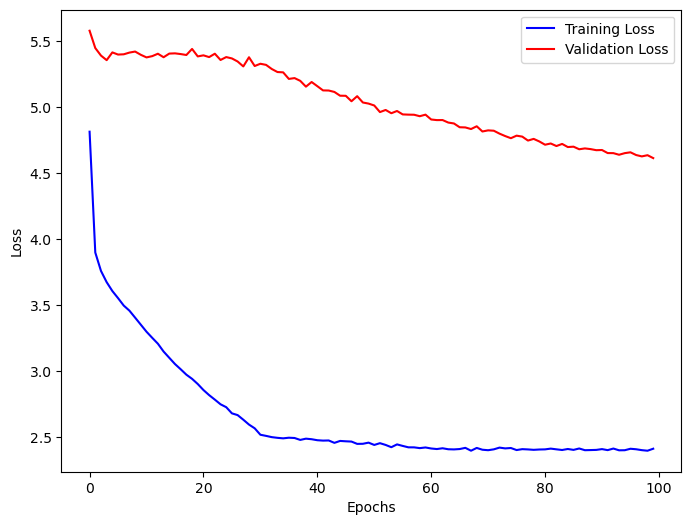

In [26]:
# Example usage
plot_loss(training_loss_array, validation_loss_array)

In [21]:
# Define the file paths for saving the models
encoder_model_path = "encoder_model.pth"
decoder_model_path = "decoder_model.pth"

# Save encoder and decoder models
torch.save(encoder.state_dict(), encoder_model_path)
torch.save(decoder.state_dict(), decoder_model_path)

print("Models saved successfully.")

Models saved successfully.


In [22]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rbalu\AppData\Roaming\nltk_data...


True

In [23]:
def metric_evaluation(encoder, decoder, validation_dataset, validation_romanian_sentence, validation_english_sentence, device):
    encoder.eval()
    decoder.eval()

    input_sentences_bleu = []
    output_sentences_bleu = []
    input_sentences_meteor = []
    output_sentences_meteor = []
    input_sentences_bert = []
    output_sentences_bert = []

    for romanian_tensor, english_tensor in validation_dataset:
        romanian_tensor = romanian_tensor.to(device).unsqueeze(0)
        english_tensor = english_tensor.to(device).unsqueeze(0)

        with torch.no_grad():
            encoder_output, encoder_hidden = encoder(romanian_tensor)
            decoder_output, _, _ = decoder(encoder_output, encoder_hidden, english_tensor)

        _, topi = decoder_output.data.topk(1)
        output_sentences = [validation_english_sentence['index_to_word'].get(token.item(), "") for token in topi.squeeze()]

        input_sentences = [validation_english_sentence['index_to_word'].get(token.item(), "") for token in english_tensor.view(-1) if token.item() in validation_english_sentence['index_to_word']]
        input_sentences_bleu.append([input_sentences])
        output_sentences_bleu.append(output_sentences)
        input_sentences_meteor.append(input_sentences)
        output_sentences_meteor.append(output_sentences)

        input_sentences_bert.append(' '.join(input_sentences))
        output_sentences_bert.append(' '.join(output_sentences))

    bleu_score = corpus_bleu(input_sentences_bleu, output_sentences_bleu)

    meteor_scores = [meteor_score([cr], cc) for cr, cc in zip(input_sentences_meteor, output_sentences_meteor)]
    meteorscore = sum(meteor_scores) / len(meteor_scores)

    P, R, F1 = bert_score(output_sentences_bert, input_sentences_bert, lang="en", verbose=True)
    bert_precision = P.mean().item()
    bert_recall = R.mean().item()
    bert_f1 = F1.mean().item()

    return bleu_score, meteorscore, bert_f1, bert_precision, bert_recall


In [24]:
bleu_score, meteorscore, bert_f1, bert_precision, bert_recall = metric_evaluation(encoder, decoder, validation_dataset, validation_romanian_sentence, validation_english_sentence, device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\rbalu\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rbalu\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/roberta-large/047c85f0b96269cd62e6f732644f067004eebd95af5b5d35965ae2528f13bf38?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1714854812&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNDg1NDgxMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yb2JlcnRhLWxhcmdlLzA0N2M4NWYwYjk2MjY5Y2Q2MmU2ZjczMjY0NGYwNjcwMDRlZWJkOTVhZjViNWQzNTk2NWFlMjUyOGYxM2JmMzg%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=WQ5tnG9xkjQBGPtpCOHxePO7h4gltijQ2PJIELj3h0l6-Qm06d00KlHj1Byra6aRjsJvavYMi0Ohgzr7SBJynEb0NLHenP5cb3-rmBX8qnS%7E%7EAumOzY605j53HDZZW00iIXSZIwvyAHlo8MSxpOEOBi6UziPavCfYH6KJS%7E1WWmISKin9yj4QEP6xSXcxzxwI0iuHIZjUj9qmuO4sA8Rd6TIGaTOW%7EaTb%7EE3NOmmc%7EJbAT8Fe-Lfk2oL9ZmAagysoi6cw2M7IZ0XFVr6RXE08T94zhOqe-YLYdfcCNqbrrcDtJaLnKNSDLuFXzRAZweEHhV-Fbn7S8yVcKZo8UzsVg__&Key-Pair-Id=KVTP0A1DKRTAX: HTTPS

model.safetensors:  71%|#######   | 1.01G/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/135 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/69 [00:00<?, ?it/s]

done in 779.91 seconds, 5.64 sentences/sec


In [25]:
print(f'Bleu Score: {bleu_score * 100:.2f}')
print(f'Meteor Score: {meteorscore * 100:.2f}')
print(f'Bert Recall: {bert_recall * 100:.2f}')
print(f'Bert Precision: {bert_precision * 100:.2f}')
print(f'Bert F1: {bert_f1 * 100:.2f}')

Bleu Score: 27.04
Meteor Score: 35.13
Bert Recall: 85.77
Bert Precision: 84.62
Bert F1: 85.18
